# Network Traffic Autoencoder Training (PyTorch)
## Anomaly Detection using Autoencoder on Benign Traffic

This notebook trains an autoencoder on benign network traffic. The idea:
- **Benign traffic** = Low reconstruction error (autoencoder learned this pattern)
- **Malicious traffic** = High reconstruction error (autoencoder struggles to reconstruct unknown patterns)

---

In [38]:
# # Install required packages (run once)
# # If you need CUDA-specific wheels, follow PyTorch install instructions for your GPU.
# !pip install torch torchvision torchaudio numpy pandas seaborn scikit-learn matplotlib

# print("\n============================================================")
# print("Installation complete. Restart the kernel, then run all cells.")
# print("============================================================")

## 1. Setup and GPU Configuration

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import pickle
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device: {device}")

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("GPU Index:", torch.cuda.current_device())
    print("GPU Count:", torch.cuda.device_count())
    
    print("GPU Properties:")
    print(torch.cuda.get_device_properties(0))
else:
    print("No CUDA-enabled GPU detected.")

PyTorch Version: 2.10.0+cu128
CUDA Available: True
Device: cuda
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
GPU Index: 0
GPU Count: 1
GPU Properties:
_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=6143MB, multi_processor_count=30, uuid=d6b18828-7a9d-e8c1-d82b-7511485d38f2, pci_bus_id=1, pci_device_id=0, pci_domain_id=0, L2_cache_size=3MB)


## 2. Load and Explore Data

In [40]:
# Load the benign traffic data
df = pd.read_csv('combined.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nTotal Samples: {len(df):,}")
print(f"Total Features: {len(df.columns)}")
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset Shape: (484557, 82)

Total Samples: 484,557
Total Features: 82

Memory Usage: 1370.51 MB


In [41]:
# Display first few rows
df.head()

,src_ip,dst_ip,src_port,dst_port,protocol,timestamp,flow_duration,flow_byts_s,flow_pkts_s,fwd_pkts_s,...,bwd_pkts_b_avg,fwd_blk_rate_avg,bwd_blk_rate_avg,fwd_seg_size_avg,bwd_seg_size_avg,cwr_flag_count,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts
0,192.168.1.152,192.168.1.195,1880,54163,2048,2019-04-04 01:38:05,120.018825,4958.205515,9.206889,4.765919,...,0.0,0.0,0.0,982.573427,62.0,0,572,533,562032,33046
1,192.168.1.152,192.168.1.195,1880,54163,2048,2019-04-04 01:38:05,120.018825,4958.205515,9.206889,4.765919,...,0.0,0.0,0.0,982.573427,62.0,0,572,533,562032,33046
2,192.168.1.152,3.122.49.24,52976,1883,2048,2019-04-04 01:38:05,119.947895,1409.245239,6.694574,3.643249,...,7.04,0.0,322.676633,323.002288,76.185792,0,437,366,141152,27884
3,127.0.0.1,127.0.0.1,42100,7878,2048,2019-04-04 01:38:05,119.000686,458.627608,3.033596,2.025198,...,0.0,0.0,0.0,80.049793,294.041667,0,241,120,19292,35285
4,192.168.1.152,3.122.49.24,52976,1883,2048,2019-04-04 01:38:05,119.947895,1409.245239,6.694574,3.643249,...,7.04,0.0,322.676633,323.002288,76.185792,0,437,366,141152,27884


In [42]:
# Check data types and missing values
print('Data Info:')
print(df.info())
print('\n' + '=' * 50)
print('\nMissing Values:')
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print('No missing values found!')

Data Info:
<class 'pandas.DataFrame'>
RangeIndex: 484557 entries, 0 to 484556
Data columns (total 82 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   src_ip             484557 non-null  str   
 1   dst_ip             484557 non-null  str   
 2   src_port           484557 non-null  object
 3   dst_port           484557 non-null  object
 4   protocol           484557 non-null  object
 5   timestamp          484557 non-null  str   
 6   flow_duration      484557 non-null  object
 7   flow_byts_s        484557 non-null  object
 8   flow_pkts_s        484557 non-null  object
 9   fwd_pkts_s         484557 non-null  object
 10  bwd_pkts_s         484557 non-null  object
 11  tot_fwd_pkts       484557 non-null  object
 12  tot_bwd_pkts       484557 non-null  object
 13  totlen_fwd_pkts    484557 non-null  object
 14  totlen_bwd_pkts    484557 non-null  object
 15  fwd_pkt_len_max    484557 non-null  object
 16  fwd_pkt_len_min    4

In [43]:
# Statistical summary
df.describe()

,src_ip,dst_ip,src_port,dst_port,protocol,timestamp,flow_duration,flow_byts_s,flow_pkts_s,fwd_pkts_s,...,bwd_pkts_b_avg,fwd_blk_rate_avg,bwd_blk_rate_avg,fwd_seg_size_avg,bwd_seg_size_avg,cwr_flag_count,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts
count,484557,484557,484557,484557,484557,484557,484557.0,484557.0,484557.0,484557.0,...,484557.0,484557.0,484557.0,484557.0,484557.0,484557,484557,484557,484557,484557
unique,1213,10259,68787,3204,5,66267,262005.0,380283.0,283923.0,280928.0,...,2362.0,35364.0,43291.0,44071.0,55198.0,3,1740,1813,22871,35829
top,192.168.10.3,192.168.10.3,123,53,17,2017-07-03 19:04:03,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,79.0,0.0,0,3,2,327,0
freq,68918,152274,5392,239402,226610,392,19009.0,19009.0,19009.0,19009.0,...,413133.0,422682.0,413133.0,22680.0,28097.0,459981,168308,181723,16324,28097


## 3. Data Preprocessing

In [44]:
# Remove non-numeric columns (IP addresses, timestamps, etc.)
non_numeric_cols = ['src_ip', 'dst_ip', 'timestamp']
existing_non_numeric = [col for col in non_numeric_cols if col in df.columns]

print(f"Removing non-numeric columns: {existing_non_numeric}")
df_numeric = df.drop(columns=existing_non_numeric, errors='ignore')

print(f"\nFeatures after removing non-numeric columns: {df_numeric.shape[1]}")
print(f"Remaining columns: {list(df_numeric.columns)}")

Removing non-numeric columns: ['src_ip', 'dst_ip', 'timestamp']

Features after removing non-numeric columns: 79
Remaining columns: ['src_port', 'dst_port', 'protocol', 'flow_duration', 'flow_byts_s', 'flow_pkts_s', 'fwd_pkts_s', 'bwd_pkts_s', 'tot_fwd_pkts', 'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max', 'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean', 'bwd_pkt_len_std', 'pkt_len_max', 'pkt_len_min', 'pkt_len_mean', 'pkt_len_std', 'pkt_len_var', 'fwd_header_len', 'bwd_header_len', 'fwd_seg_size_min', 'fwd_act_data_pkts', 'flow_iat_mean', 'flow_iat_max', 'flow_iat_min', 'flow_iat_std', 'fwd_iat_tot', 'fwd_iat_max', 'fwd_iat_min', 'fwd_iat_mean', 'fwd_iat_std', 'bwd_iat_tot', 'bwd_iat_max', 'bwd_iat_min', 'bwd_iat_mean', 'bwd_iat_std', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags', 'bwd_urg_flags', 'fin_flag_cnt', 'syn_flag_cnt', 'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt'

In [45]:
# Handle any infinite or NaN values
print('Checking for infinite values...')
inf_count = np.isinf(df_numeric.select_dtypes(include=[np.number])).sum().sum()
print(f"Infinite values found: {inf_count}")

if inf_count > 0:
    print('Replacing infinite values with NaN...')
    df_numeric = df_numeric.replace([np.inf, -np.inf], np.nan)

nan_count = df_numeric.isnull().sum().sum()
if nan_count > 0:
    print(f"\nFilling {nan_count} NaN values with column medians...")
    df_numeric = df_numeric.fillna(df_numeric.median())

print('\nEnsuring all data is numeric...')
for col in df_numeric.columns:
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

rows_before = len(df_numeric)
df_numeric = df_numeric.dropna()
rows_after = len(df_numeric)
if rows_before != rows_after:
    print(f"Dropped {rows_before - rows_after} rows with non-numeric values")

df_numeric = df_numeric.reset_index(drop=True)

print('\nData cleaning complete!')
print(f"Final dataset shape: {df_numeric.shape}")

Checking for infinite values...
Infinite values found: 0.0

Ensuring all data is numeric...
Dropped 3 rows with non-numeric values

Data cleaning complete!
Final dataset shape: (484554, 79)


In [46]:
# Split data into train and test sets
X_train, X_test = train_test_split(df_numeric, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

print(f"Training Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")
print('\nData types in training set:')
print(X_train.dtypes.value_counts())

Training Set: (387643, 79)
Test Set: (96911, 79)

Data types in training set:
float64    79
Name: count, dtype: int64


In [47]:
# Normalize the data
print('Verifying data types before scaling...')
print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print('\nData types in X_train:')
print(X_train.dtypes.value_counts())
print('\nSample of first row:')
print(X_train.iloc[0][:5])

if X_train.shape[0] == 0:
    raise ValueError('X_train is empty! Check the data preprocessing steps.')

print('\nConverting all columns to float64...')
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

print('After conversion - X_train dtypes:')
print(X_train.dtypes.value_counts())

print('\nScaling data...')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('\nScaling successful!')
print(f"Scaled Training Data Shape: {X_train_scaled.shape}")
print(f"Scaled Test Data Shape: {X_test_scaled.shape}")
print(f"Input Dimension (number of features): {X_train_scaled.shape[1]}")

Verifying data types before scaling...
X_train type: <class 'pandas.DataFrame'>
X_train shape: (387643, 79)

Data types in X_train:
float64    79
Name: count, dtype: int64

Sample of first row:
src_port          53606.000000
dst_port             53.000000
protocol             17.000000
flow_duration         0.000887
flow_byts_s      602029.312289
Name: 0, dtype: float64

Converting all columns to float64...
After conversion - X_train dtypes:
float64    79
Name: count, dtype: int64

Scaling data...

Scaling successful!
Scaled Training Data Shape: (387643, 79)
Scaled Test Data Shape: (96911, 79)
Input Dimension (number of features): 79


## 4. Build Autoencoder Model

The autoencoder has two parts:
- **Encoder**: Compresses the input into a smaller representation (bottleneck)
- **Decoder**: Reconstructs the original input from the compressed representation

Architecture:
```
Input -> [Encoder] -> Bottleneck -> [Decoder] -> Reconstructed Output
```

In [48]:
# Hyperparameters
input_dim = X_train_scaled.shape[1]
encoding_dim = 16

print(f"Input Dimension: {input_dim}")
print(f"Encoding Dimension (Bottleneck): {encoding_dim}")
print(f"Compression Ratio: {input_dim / encoding_dim:.2f}x")

Input Dimension: 79
Encoding Dimension (Bottleneck): 16
Compression Ratio: 4.94x


In [49]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, encoding_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            
            nn.Linear(64, input_dim)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(input_dim, encoding_dim).to(device)
print('Autoencoder model built successfully.')

Autoencoder model built successfully.


In [50]:
# Prepare DataLoaders
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Create validation split
val_size = int(0.2 * len(X_train_tensor))
train_size = len(X_train_tensor) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(
    TensorDataset(X_train_tensor),
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 4846
Val batches: 1212
Test batches: 1515


## 5. Train the Autoencoder

In [51]:
EPOCHS = 100
LEARNING_RATE = 1e-3

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7
)

best_val_loss = float('inf')
patience = 10
patience_counter = 0

history = {
    'loss': [],
    'val_loss': [],
    'mae': [],
    'val_mae': []
}

for epoch in range(1, EPOCHS + 1):
    autoencoder.train()
    train_losses = []
    train_mae = []

    for (batch_x,) in train_loader:
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(batch_x)
        loss = criterion(outputs, batch_x)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_mae.append(torch.mean(torch.abs(outputs - batch_x)).item())

    autoencoder.eval()
    val_losses = []
    val_mae = []

    with torch.no_grad():
        for (batch_x,) in val_loader:
            batch_x = batch_x.to(device)
            outputs = autoencoder(batch_x)
            val_loss = criterion(outputs, batch_x)
            val_losses.append(val_loss.item())
            val_mae.append(torch.mean(torch.abs(outputs - batch_x)).item())

    avg_train_loss = float(np.mean(train_losses))
    avg_val_loss = float(np.mean(val_losses))
    avg_train_mae = float(np.mean(train_mae))
    avg_val_mae = float(np.mean(val_mae))

    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['mae'].append(avg_train_mae)
    history['val_mae'].append(avg_val_mae)

    scheduler.step(avg_val_loss)

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | "
        f"Train MAE: {avg_train_mae:.6f} | Val MAE: {avg_val_mae:.6f}"
    )

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(autoencoder.state_dict(), 'best_autoencoder.pt')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print('Early stopping triggered.')
        break

print('Training complete.')

Epoch 01/100 | Train Loss: 0.297436 | Val Loss: 0.165434 | Train MAE: 0.157196 | Val MAE: 0.137752
Epoch 02/100 | Train Loss: 0.178873 | Val Loss: 0.236584 | Train MAE: 0.142888 | Val MAE: 0.104392
Epoch 03/100 | Train Loss: 0.154720 | Val Loss: 0.103525 | Train MAE: 0.132962 | Val MAE: 0.111176
Epoch 04/100 | Train Loss: 0.158102 | Val Loss: 0.104270 | Train MAE: 0.131438 | Val MAE: 0.115424
Epoch 05/100 | Train Loss: 0.145099 | Val Loss: 0.175100 | Train MAE: 0.127042 | Val MAE: 0.082540
Epoch 06/100 | Train Loss: 0.131920 | Val Loss: 0.133034 | Train MAE: 0.122923 | Val MAE: 0.073767
Epoch 07/100 | Train Loss: 0.131861 | Val Loss: 0.087323 | Train MAE: 0.119060 | Val MAE: 0.067388
Epoch 08/100 | Train Loss: 0.120872 | Val Loss: 0.317970 | Train MAE: 0.117270 | Val MAE: 0.289065
Epoch 09/100 | Train Loss: 0.118349 | Val Loss: 0.068637 | Train MAE: 0.115318 | Val MAE: 0.068001
Epoch 10/100 | Train Loss: 0.126244 | Val Loss: 0.063333 | Train MAE: 0.116778 | Val MAE: 0.072070
Epoch 11/1

## 6. Visualize Training Progress

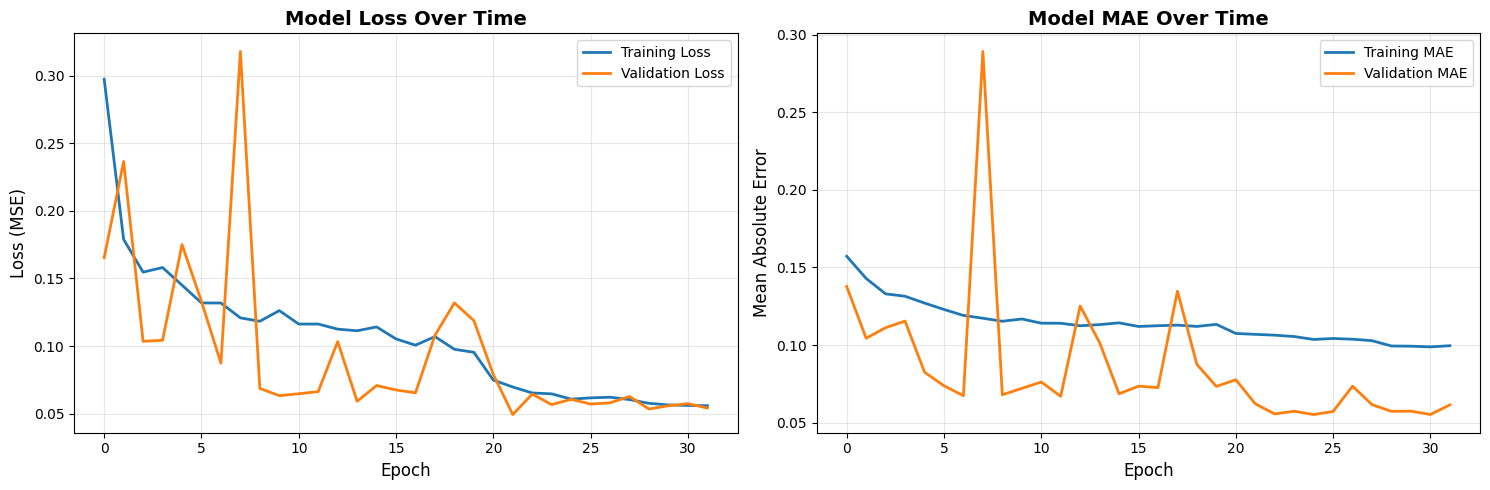

Training plots saved as training_history.png


In [61]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Mean Absolute Error', fontsize=12)
axes[1].set_title('Model MAE Over Time', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print('Training plots saved as training_history.png')

## 7. Evaluate on Benign Test Data

In [62]:
# Load best model for evaluation
autoencoder.load_state_dict(torch.load('best_autoencoder.pt', map_location=device))
autoencoder.eval()

with torch.no_grad():
    X_test_reconstructed = autoencoder(X_test_tensor.to(device)).cpu().numpy()

mse_per_sample = np.mean(np.square(X_test_scaled - X_test_reconstructed), axis=1)
mae_per_sample = np.mean(np.abs(X_test_scaled - X_test_reconstructed), axis=1)

print('Reconstruction Error Statistics on Benign Test Data:')
print('=' * 60)
print('\nMean Squared Error (MSE):')
print(f"  Mean: {np.mean(mse_per_sample):.6f}")
print(f"  Median: {np.median(mse_per_sample):.6f}")
print(f"  Std Dev: {np.std(mse_per_sample):.6f}")
print(f"  Min: {np.min(mse_per_sample):.6f}")
print(f"  Max: {np.max(mse_per_sample):.6f}")

print('\nMean Absolute Error (MAE):')
print(f"  Mean: {np.mean(mae_per_sample):.6f}")
print(f"  Median: {np.median(mae_per_sample):.6f}")
print(f"  Std Dev: {np.std(mae_per_sample):.6f}")
print(f"  Min: {np.min(mae_per_sample):.6f}")
print(f"  Max: {np.max(mae_per_sample):.6f}")

Reconstruction Error Statistics on Benign Test Data:

Mean Squared Error (MSE):
  Mean: 0.136411
  Median: 0.003262
  Std Dev: 13.737039
  Min: 0.001330
  Max: 1978.635485

Mean Absolute Error (MAE):
  Mean: 0.063631
  Median: 0.040562
  Std Dev: 0.243227
  Min: 0.024725
  Max: 31.142049


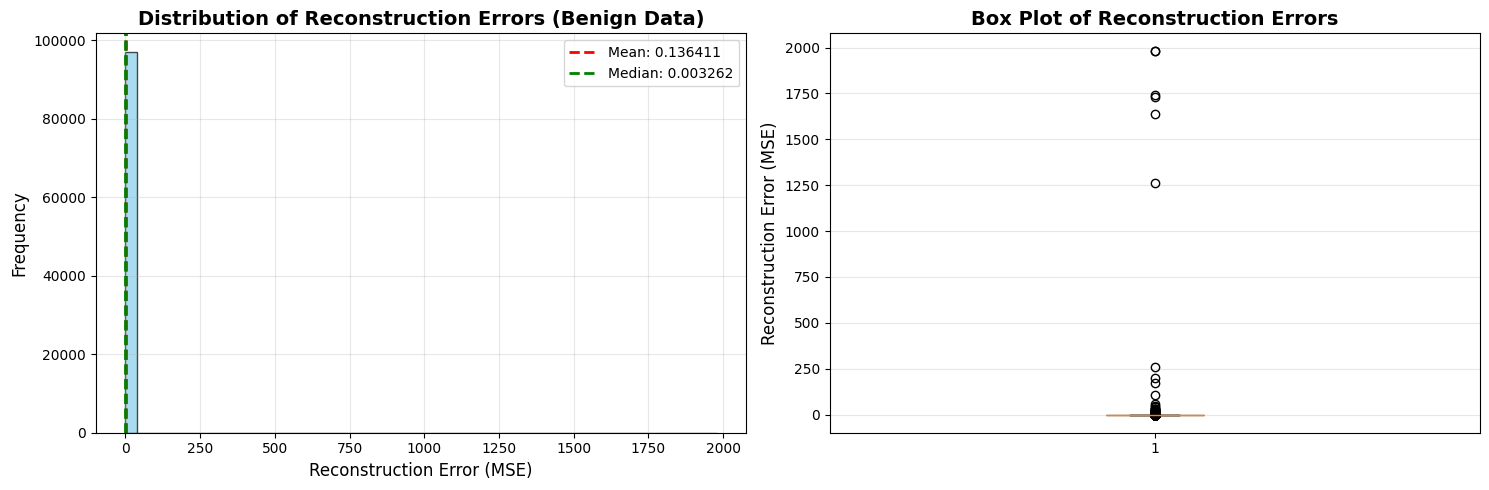

Reconstruction error plots saved as benign_reconstruction_errors.png


In [63]:
# Visualize reconstruction errors
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(mse_per_sample, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(np.mean(mse_per_sample), color='red', linestyle='--',
                linewidth=2, label=f"Mean: {np.mean(mse_per_sample):.6f}")
axes[0].axvline(np.median(mse_per_sample), color='green', linestyle='--',
                linewidth=2, label=f"Median: {np.median(mse_per_sample):.6f}")
axes[0].set_xlabel('Reconstruction Error (MSE)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Reconstruction Errors (Benign Data)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(mse_per_sample, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_ylabel('Reconstruction Error (MSE)', fontsize=12)
axes[1].set_title('Box Plot of Reconstruction Errors', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('benign_reconstruction_errors.png', dpi=300, bbox_inches='tight')
plt.show()

print('Reconstruction error plots saved as benign_reconstruction_errors.png')

In [64]:
# Calculate threshold for anomaly detection
threshold_95 = np.percentile(mse_per_sample, 95)
threshold_99 = np.percentile(mse_per_sample, 99)
threshold_mean_3std = np.mean(mse_per_sample) + 3 * np.std(mse_per_sample)

print('\nAnomaly Detection Thresholds:')
print('=' * 60)
print(f"95th Percentile: {threshold_95:.6f}")
print(f"99th Percentile: {threshold_99:.6f}")
print(f"Mean + 3xStd: {threshold_mean_3std:.6f}")
print('\nRecommendation: Use 95th percentile as threshold for anomaly detection.')
print(f"Reconstruction error > {threshold_95:.6f} = Potential Anomaly")


Anomaly Detection Thresholds:
95th Percentile: 0.058508
99th Percentile: 0.209656
Mean + 3xStd: 41.347526

Recommendation: Use 95th percentile as threshold for anomaly detection.
Reconstruction error > 0.058508 = Potential Anomaly


## 8. Test on Malicious Data (Optional)

**To test on malicious traffic:**
1. Load your malicious CSV file
2. Apply the same preprocessing
3. Calculate reconstruction errors
4. Compare with benign threshold

In [56]:
# Example code to test on malicious data
# Uncomment and modify the file path when you have malicious data

# df_malicious = pd.read_csv('malicious_traffic.csv')
# df_mal_numeric = df_malicious.drop(columns=existing_non_numeric, errors='ignore')
# df_mal_numeric = df_mal_numeric.replace([np.inf, -np.inf], np.nan)
# df_mal_numeric = df_mal_numeric.fillna(df_mal_numeric.median())
#
# missing_cols = set(df_numeric.columns) - set(df_mal_numeric.columns)
# for col in missing_cols:
#     df_mal_numeric[col] = 0
# df_mal_numeric = df_mal_numeric[df_numeric.columns]
#
# X_malicious_scaled = scaler.transform(df_mal_numeric)
# X_mal_tensor = torch.tensor(X_malicious_scaled, dtype=torch.float32).to(device)
#
# autoencoder.eval()
# with torch.no_grad():
#     X_mal_reconstructed = autoencoder(X_mal_tensor).cpu().numpy()
#
# mse_malicious = np.mean(np.square(X_malicious_scaled - X_mal_reconstructed), axis=1)
#
# print('Malicious Data Reconstruction Errors:')
# print(f"  Mean MSE: {np.mean(mse_malicious):.6f}")
# print(f"  Median MSE: {np.median(mse_malicious):.6f}")
# print('\nComparison:')
# print(f"  Benign Mean MSE: {np.mean(mse_per_sample):.6f}")
# print(f"  Malicious Mean MSE: {np.mean(mse_malicious):.6f}")
# print(f"  Ratio: {np.mean(mse_malicious) / np.mean(mse_per_sample):.2f}x higher")
#
# anomalies_detected = np.sum(mse_malicious > threshold_95)
# detection_rate = (anomalies_detected / len(mse_malicious)) * 100
# print(f"\nAnomaly Detection Rate: {detection_rate:.2f}%")
# print(f"  ({anomalies_detected:,} out of {len(mse_malicious):,} samples)")

print('Uncomment the code above and provide malicious data CSV to test.')

Uncomment the code above and provide malicious data CSV to test.


## 9. Visualize Sample Reconstructions

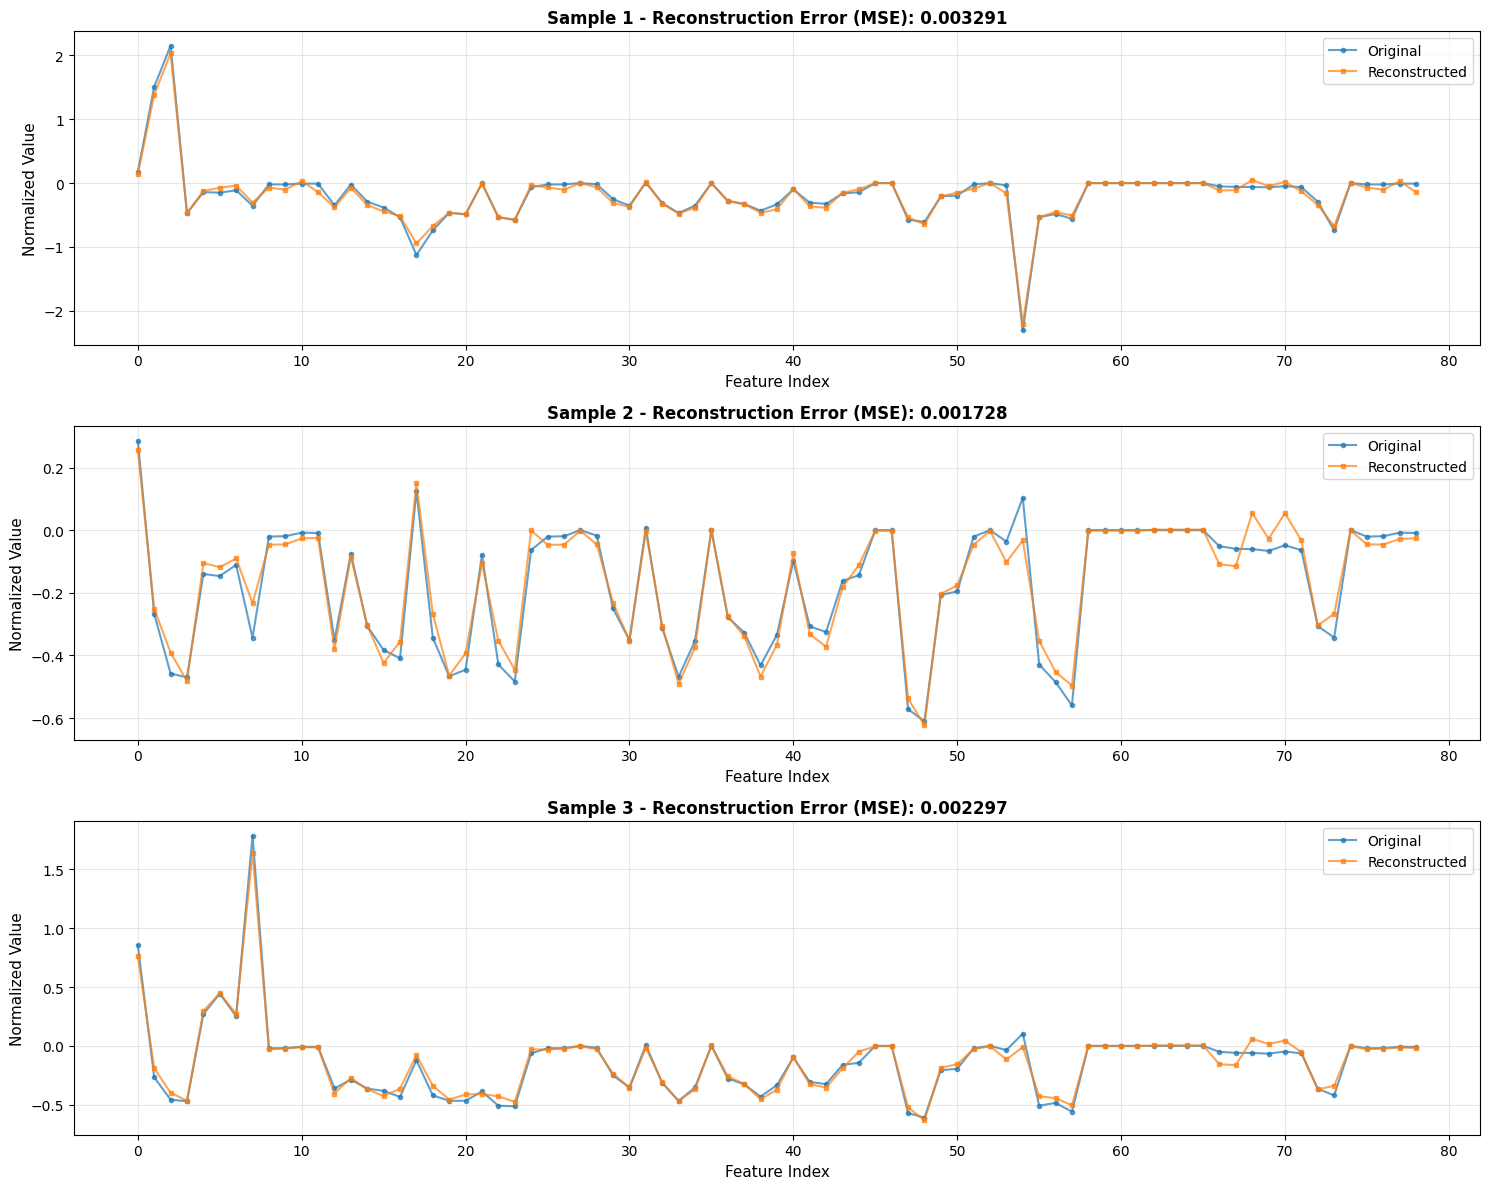

Sample reconstruction plots saved as sample_reconstructions.png


In [65]:
num_samples = 3
sample_indices = np.random.choice(len(X_test_scaled), num_samples, replace=False)

fig, axes = plt.subplots(num_samples, 1, figsize=(15, 4 * num_samples))
if num_samples == 1:
    axes = [axes]

for i, idx in enumerate(sample_indices):
    original = X_test_scaled[idx]
    reconstructed = X_test_reconstructed[idx]
    error = mse_per_sample[idx]
    x_axis = np.arange(len(original))
    axes[i].plot(x_axis, original, 'o-', label='Original', alpha=0.7, markersize=3)
    axes[i].plot(x_axis, reconstructed, 's-', label='Reconstructed', alpha=0.7, markersize=3)
    axes[i].set_xlabel('Feature Index', fontsize=11)
    axes[i].set_ylabel('Normalized Value', fontsize=11)
    axes[i].set_title(
        f"Sample {i+1} - Reconstruction Error (MSE): {error:.6f}",
        fontsize=12, fontweight='bold'
    )
    axes[i].legend(fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sample_reconstructions.png', dpi=300, bbox_inches='tight')
plt.show()

print('Sample reconstruction plots saved as sample_reconstructions.png')

## 10. Save Model and Artifacts

In [66]:
# Save the trained autoencoder
torch.save(autoencoder.state_dict(), 'autoencoder_final.pt')
print('Full autoencoder saved as autoencoder_final.pt')

# Save the encoder separately
torch.save(autoencoder.encoder.state_dict(), 'encoder_final.pt')
print('Encoder saved as encoder_final.pt')

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print('Scaler saved as scaler.pkl')

params = {
    'input_dim': input_dim,
    'encoding_dim': encoding_dim,
    'feature_columns': list(df_numeric.columns),
    'threshold_95': threshold_95,
    'threshold_99': threshold_99,
    'threshold_mean_3std': threshold_mean_3std,
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'mean_mse_benign': float(np.mean(mse_per_sample)),
    'std_mse_benign': float(np.std(mse_per_sample))
}

with open('model_params.pkl', 'wb') as f:
    pickle.dump(params, f)
print('Model parameters saved as model_params.pkl')

print('All models and artifacts saved successfully.')

Full autoencoder saved as autoencoder_final.pt
Encoder saved as encoder_final.pt
Scaler saved as scaler.pkl
Model parameters saved as model_params.pkl
All models and artifacts saved successfully.


## 11. Load and Use Saved Model (Example)

In [59]:
# Example: How to load and use the saved model later
# loaded_autoencoder = Autoencoder(input_dim, encoding_dim).to(device)
# loaded_autoencoder.load_state_dict(torch.load('autoencoder_final.pt', map_location=device))
# loaded_autoencoder.eval()
#
# with open('scaler.pkl', 'rb') as f:
#     loaded_scaler = pickle.load(f)
#
# with open('model_params.pkl', 'rb') as f:
#     loaded_params = pickle.load(f)
#
# new_data_scaled = loaded_scaler.transform(new_data)
# new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32).to(device)
# with torch.no_grad():
#     reconstructed = loaded_autoencoder(new_data_tensor).cpu().numpy()
# mse = np.mean(np.square(new_data_scaled - reconstructed), axis=1)
# is_anomaly = mse > loaded_params['threshold_95']

print('Uncomment the code above to see how to load and use the saved model.')

Uncomment the code above to see how to load and use the saved model.


## 12. Summary and Next Steps

In [67]:
print('\n' + '=' * 60)
print('TRAINING SUMMARY')
print('=' * 60)
print('\nDataset:')
print(f"  Total samples: {len(df):,}")
print(f"  Features: {input_dim}")
print(f"  Training samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")

print('\nModel Architecture:')
print(f"  Input dimension: {input_dim}")
print(f"  Encoding dimension: {encoding_dim}")
print(f"  Compression ratio: {input_dim / encoding_dim:.2f}x")
print(f"  Total parameters: {sum(p.numel() for p in autoencoder.parameters()):,}")

print('\nPerformance on Benign Data:')
print(f"  Mean MSE: {np.mean(mse_per_sample):.6f}")
print(f"  Median MSE: {np.median(mse_per_sample):.6f}")
print(f"  Std Dev: {np.std(mse_per_sample):.6f}")

print('\nAnomaly Detection Threshold:')
print(f"  95th Percentile: {threshold_95:.6f}")
print('  Use this threshold to detect malicious traffic.')

print('\nSaved Files:')
print('  autoencoder_final.pt (Full model)')
print('  encoder_final.pt (Encoder only)')
print('  scaler.pkl (Data normalizer)')
print('  model_params.pkl (Parameters and thresholds)')
print('  training_history.png')
print('  benign_reconstruction_errors.png')
print('  sample_reconstructions.png')

print('\n' + '=' * 60)
print('NEXT STEPS:')
print('=' * 60)
print('\n1. Test on malicious data using section 8')
print('2. Experiment with different encoding dimensions')
print('3. Try different architectures (add/remove layers)')
print('4. Adjust the anomaly detection threshold')
print('5. Use the model in your application for real-time detection')
print('\n' + '=' * 60)


TRAINING SUMMARY

Dataset:
  Total samples: 484,557
  Features: 79
  Training samples: 387,643
  Test samples: 96,911

Model Architecture:
  Input dimension: 79
  Encoding dimension: 16
  Compression ratio: 4.94x
  Total parameters: 15,903

Performance on Benign Data:
  Mean MSE: 0.136411
  Median MSE: 0.003262
  Std Dev: 13.737039

Anomaly Detection Threshold:
  95th Percentile: 0.058508
  Use this threshold to detect malicious traffic.

Saved Files:
  autoencoder_final.pt (Full model)
  encoder_final.pt (Encoder only)
  scaler.pkl (Data normalizer)
  model_params.pkl (Parameters and thresholds)
  training_history.png
  benign_reconstruction_errors.png
  sample_reconstructions.png

NEXT STEPS:

1. Test on malicious data using section 8
2. Experiment with different encoding dimensions
3. Try different architectures (add/remove layers)
4. Adjust the anomaly detection threshold
5. Use the model in your application for real-time detection

